In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def integral(Y1,Y2,E1,E2):
    INT=(Y2*E2-Y1*E1)/((np.log(Y2/Y1)/np.log(E2/E1)+1))
    #print(E1,E2,INT)
    return INT

def load_obj(name):
    with open('C:\\Users\\ginti\\Desktop\\nirs\\' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def Y_NM_Mi20_a(energy,h):
    P=np.sqrt(energy*energy+2*0.938*energy)
    X=np.log(P)
    if energy<1.7:
        a,b,c,d=0.5082, -3.0659, 7.2827, -9.5396
    #if energy<1.6:
    #    a,b,c,d=2.0404,	-8.1776,	12.354,	-11.1
    elif (energy>=1.7 and energy<15):
        a,b,c,d=0.1179,	-1.2022,	4.9329,	-8.65
    else:
        a,b,c,d=0,	-0.0365,	1.206,	-4.763
    LnY1000=a*X*X*X+b*X*X+c*X+d
    Y1000=np.exp(LnY1000)
    A = 9.422E-09*np.power(X,5) - 2.284E-07*np.power(X,4) + 2.037E-06*np.power(X,3) - 7.828E-06*np.power(X,2) + 1.203E-05*np.power(X,1) - 5.545E-06					
    B = -5.351E-06*np.power(X,5) + 1.316E-04*np.power(X,4) - 1.226E-03*np.power(X,3) + 5.176E-03*np.power(X,2) - 1.017E-02*np.power(X,1) + 1.458E-02				
    alt_dep=(1000-h)*(1000-h)*A+(1000-h)*B
    Y=Y1000*np.exp(alt_dep)
    return Y

def Y_NM_Mi20_p(energy, h):
    P=np.sqrt(energy*energy+2*0.938*energy)
    X=np.log(P)
    #if energy<1.25:
    #    a,b,c,d=6.09,	-14.06,	13.98,	-11.615
    if energy<1.28:
        a,b,c,d=0,	-8.6616,	13.879,	-12.104
    elif energy >=1.28 and energy<10:
        a,b,c,d=-0.186,	0.428,	2.831,	-8.76
    else:
        a,b,c,d=0,	-0.0365,	1.206,	-4.763
    LnY1000=a*X*X*X+b*X*X+c*X+d
    Y1000=np.exp(LnY1000)
    A= 6.945E-09*np.power(X,5) - 1.461E-07*np.power(X,4) + 1.115E-06*np.power(X,3) - 3.402E-06*np.power(X,2) + 3.355E-06*np.power(X,1) - 9.823E-07
    B= -3.963E-06*np.power(X,5) + 8.091E-05*np.power(X,4) - 6.394E-04*np.power(X,3) + 2.348E-03*np.power(X,2) - 4.713E-03*np.power(X,1) + 1.186E-02
    alt_dep=(1000-h)*(1000-h)*A+(1000-h)*B
    Y=Y1000*np.exp(alt_dep)
    return Y

In [2]:
def heppam(ener):
    
    data_protons = load_obj('p_PAM_CR')
    data_he = load_obj('a_PAM_CR')

    newprot = []

    for k in data_protons:
        x = np.log10(data_protons[k][0])
        y = np.log10(data_protons[k][2])
        f = interpolate.interp1d(x, y, fill_value="extrapolate")

        xnew = np.log10(data_he[k][0])
        ynew=f(xnew)

        newprot.append(10**ynew)
        
        
    iheavy = open('C:\\Users\\ginti\\Desktop\\nirs\\heavyp.txt','r')
    linesiheavy = iheavy.readlines()
    heavy = []
    for x in linesiheavy:
        heavy.append(x.split()[0])
    iheavy.close()

    l = 0
    hep = []
    meh = []

    for i in data_he:
        a = (float(data_he[i].iloc[[ener], [2]].values))*(1 + float(heavy[ener]))/float(newprot[l][ener])
        hep.append(a)                
        l+=1
        
    return hep

In [10]:
def summ1(pc,depth):
    
    tt = depth
    
    data_protons = load_obj('p_PAM_CR')
    data_he = load_obj('a_PAM_CR')
    
    al = []
    s1 = 0
    
    for j in data_protons:
        for k in range(0,98):
            if float(data_protons[j].iloc[[k], [0]].values) > pc:            
                a = float(data_protons[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_p(a,tt) * float(data_protons[j].iloc[[k], [6]].values)
                c = float(data_protons[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_p(c,tt) * float(data_protons[j].iloc[[k+1], [6]].values)
                s1 += integral(b, d, a, c)
        al.append(s1)
        s1 = 0
        
    s2 = 0
    an = []
    
    iheavy = open('C:\\Users\\ginti\\Desktop\\nirs\\heavyp.txt','r')
    linesiheavy = iheavy.readlines()
    heavy = []
    for x in linesiheavy:
        heavy.append(x.split()[0])
    iheavy.close()
    
    for j in data_he:
        for k in range(0,49):        
            if float(data_he[j].iloc[[k], [0]].values) > pc:
                a = float(data_he[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_a(a,tt) * float(data_he[j].iloc[[k], [6]].values) * (1 + float(heavy[k]))
                c = float(data_he[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_a(c,tt) * float(data_he[j].iloc[[k+1], [6]].values)  * (1 + float(heavy[k]))
                s2 += integral(b, d, a, c)
        an.append(4*s2)
        s2 = 0
    nn = []
    
    for i in range(len(an)):
        phe = al[i] + an[i]
        nn.append(phe)
        
    return nn

In [11]:
time = load_obj('time_PAM_CR')
t = []
for j in range(0, 51):
    a = float(time.iloc[[j], [0]].values)
    t.append(a)

In [6]:
n57 = summ1(6.90668,886.94)
nn57 = []
for i in n57:
    nn57.append(i/(sum(n57)/len(n57)))
n010 = summ1(0,1025.07)
nn010 = []
for i in n010:
    nn010.append(i/(sum(n010)/len(n010)))

Text(0, 0.5, '$NM_{1}/NM_{2}$')

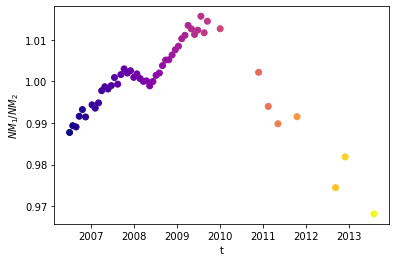

In [7]:
nnn=[]
for i in range(len(n57)):
    a=nn010[i]/nn57[i]
    nnn.append(a)
    
fig = plt.figure()
plt.scatter(t, nnn, c=t, cmap="plasma")
plt.xlabel('t')
plt.ylabel('$NM_{1}/NM_{2}$')

In [8]:
data_he = load_obj('a_PAM_CR')

In [9]:
print(data_he)

{2045:               0           1          2         3         4        5  \
0      0.927816    0.065096  41.667650  1.709803    0.1095   0.0145   
1      1.065476    0.072564  58.173669  2.134234    0.1420   0.0180   
2      1.221973    0.083933  70.597033  2.438233    0.1830   0.0230   
3      1.402419    0.096513  77.722455  2.598249    0.2350   0.0290   
4      1.610639    0.111707  81.857907  2.674993    0.3005   0.0365   
5      1.850166    0.127820  80.319036  2.471336    0.3820   0.0450   
6      2.124400    0.146414  74.466138  2.284807    0.4820   0.0550   
7      2.438306    0.167492  66.162566  2.029890    0.6035   0.0665   
8      2.799313    0.193515  56.998769  1.751923    0.7505   0.0805   
9      3.214856    0.222028  46.060733  1.400761    0.9270   0.0960   
10     3.687860    0.257803  37.331633  1.141138    1.1350   0.1150   
11     4.240682    0.295020  29.440189  0.906678    1.3850   0.1350   
12     4.867732    0.332030  22.267446  0.693378    1.6750   0.1550   

In [12]:
hepp = []
for k in range(len(data_he[2049])):
    he = heppam(k)
    hepp.append(he)

In [14]:
hepp

[[0.06345039044358367,
  0.06108495035207633,
  0.05953287354137109,
  0.055360804731925235,
  0.05776300138313357,
  0.058994642607419795,
  0.0588744280565951,
  0.059665794057926914,
  0.06338121109022758,
  0.06426437719706968,
  0.060527316335213986,
  0.057441316667992896,
  0.059212628188845595,
  0.05830135993720112,
  0.05908057316810256,
  0.062037606700308064,
  0.06430015636416316,
  0.056882430831809036,
  0.05915115133023351,
  0.060168803612255094,
  0.06114285178439089,
  0.06103376164334961,
  0.06292485398198884,
  0.0644140130272903,
  0.06102604871514473,
  0.06878668162087304,
  0.06240798668223324,
  0.06666104546275659,
  0.06530239438956724,
  0.06263157606988567,
  0.060405523362287265,
  0.06105661833037061,
  0.05743564920613327,
  0.062379271560358586,
  0.06227351868736798,
  0.06149710336458165,
  0.06030412975219887,
  0.06547762547394817,
  0.06622178096525964,
  0.06587486711564886,
  0.06866466390538914,
  0.06593819719205782,
  0.06959857169495988,
  

In [15]:
corr = []
for k in hepp:
    x = np.array(k).reshape((-1, 1))
    y = np.array(nnn)
    model = LinearRegression().fit(x, y)

    x_train = x.reshape(-1, 1)
    x_test = x.reshape(-1, 1)
    y_pred = model.predict(x_test)
    coefficient_of_dermination2 = r2_score(y, y_pred)
    corr.append(coefficient_of_dermination2)

print(corr)

[0.010200280055011501, 0.07962097179221661, 0.0012509074858451097, 0.06336971343764397, 0.12260052328860882, 0.06696557178052565, 0.028788590951239312, 0.00019491269384031007, 0.0015893977571006523, 0.0003916261421382794, 0.00939643163184245, 0.011913109498441932, 0.04995591169326563, 0.04798040518816993, 8.684493522670422e-05, 0.024077753660027623, 0.1022452106304007, 0.0060231950092880515, 3.397214126499293e-05, 0.017300756858964705, 3.909817276270822e-06, 0.07066506963730557, 0.010584692346094493, 0.06964322649238175, 0.0024717901095996364, 0.005614642448676599, 0.0797220487496999, 0.3114732235820832, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [16]:
corr1 = [0.7227132692252316,
 0.7776223193904133,
 0.756677524775461,
 0.6008815622044086,
 0.4261026627957295,
 0.2115112236845451,
 0.2837733093360898,
 0.08641969027612895,
 0.005550455211678407,
 0.01684554761963264,
 0.013917257504378666,
 0.03691377089467307,
 0.012141442388318824,
 0.06340976589483538,
 0.012689677391623966,
 0.0002962356497018259,
 0.00030044771744142107,
 0.005065285707738676,
 0.0010394131532592832,
 0.009595457006181252,
 0.0018308139094486142,
 0.010486163246038793,
 0.005541535810338338,
 0.002676439307944256,
 2.5450941354421275e-10,
 0.03117749743778253,
 0.00032493047549386755,
 0.0615052421616511,
 0.0007061092994061768,
 0.019823206048379283,
 0.0035524463572884635,
 0.0034056758391587394,
 0.025439101986318158,
 9.8939448156532e-07,
 0.006522783809890242,
 0.030939931419228683,
 0.0170679144022281,
 0.008764378512356785,
 0.05692223901032267,
 0.0013621543839457129]

Text(0, 0.5, 'Corr')

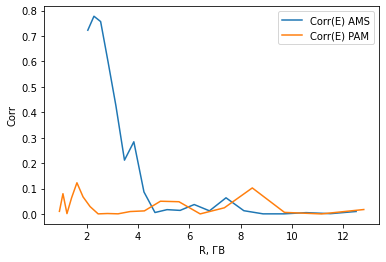

In [17]:
ener = data_he[2045][0]
data_he1 = load_obj('AMS_spec_he')
ener1 = data_he1[2426][0]

fig, ax = plt.subplots()
ax.plot(ener1[:20], corr1[:20])
ax.plot(ener[:20], corr[:20])

ax.legend(["Corr(E) AMS", "Corr(E) PAM"])
ax.set_xlabel("R, ГВ")
ax.set_ylabel("Corr")